# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning
 - Confusion matrix

Report:
 - Structure of CNN model
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [1]:
!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

Downloading...
From (original): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi
From (redirected): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi&confirm=t&uuid=3ce8785b-c97d-427e-9249-41b4723335d3
To: /content/HW2.zip
100% 52.1M/52.1M [00:00<00:00, 211MB/s]


#### Import packages

In [2]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torchsummary import summary
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [116]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 256,
    n_epoch = 50,
    lr = 2e-3,
    weight_decay = 1e-7,
    ckpt_path = 'model.pth',
)

In [117]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

cuda


#### Dataset and Dataloader

In [118]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [119]:
# TODO: define your augmentation for training and evaluation
train_tfm = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=20, scale=(0.9, 1.1)),
    T.ToTensor(),

])
eval_tfm = T.Compose([
    T.ToTensor(),
])

In [120]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)

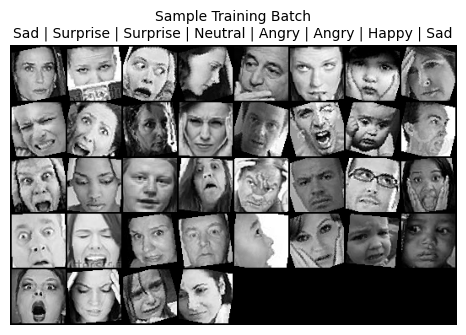

In [121]:
import matplotlib.pyplot as plt
import torchvision

def show_batch(images, labels, classes=None, nrow=8, title="Sample Training Batch"):
    """
    Visualize a batch of images from a DataLoader.

    Args:
        images (Tensor): Batch of images [B, C, H, W]
        labels (Tensor): Corresponding labels [B]
        classes (list, optional): Class names corresponding to label indices.
        nrow (int): Number of images per row in the grid.
        title (str): Title for the plot.
    """
    # Denormalize (if you used normalization in transforms)
    img = images.clone()
    select = [i for i, x in enumerate(labels.tolist()) if x == 2]
    img = img[select]


    # Make grid
    grid = torchvision.utils.make_grid(img, nrow=nrow, padding=2)
    plt.figure(figsize=(nrow * 0.72, nrow * 0.72))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")

    # Add labels below each image
    if classes is not None:
        label_texts = [classes[l.item()] if isinstance(l.item(), int) else str(l) for l in labels[:nrow]]
        plt.title(f"{title}\n" + " | ".join(label_texts), fontsize=10)
    else:
        plt.title(title)

    plt.show()

# Get a batch
images, labels = next(iter(train_loader))

# Define your class names (adjust to your dataset)
classes = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Visualize
show_batch(images, labels, classes=classes)

#### Model

In [122]:
# TODO: define your CNN model
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
          nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
          nn.Linear(512 * 4 * 4, 128),
          nn.ReLU(),
          nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 512 * 4 * 4)
        x = self.fc(x)
        return x

#### training loop

In [123]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_acc = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(config.n_epoch), train_losses, label='Training Loss')
    plt.plot(range(config.n_epoch), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         295,168
      BatchNorm2d-10          [-1, 256, 16, 16]             512
             ReLU-11          [-1, 256, 16, 16]               0
        MaxPool2d-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 8, 8]       1,180,160
      BatchNorm2d-14            [-1, 51

100%|██████████| 91/91 [00:19<00:00,  4.77it/s]


Epoch: 1/50, train loss: 2.2082, train acc: 0.2388
Epoch: 1/50, valid loss: 1.7746, valid acc: 0.2639
== best valid acc: 0.2639 ==


100%|██████████| 91/91 [00:18<00:00,  4.88it/s]


Epoch: 2/50, train loss: 1.6905, train acc: 0.3220
Epoch: 2/50, valid loss: 1.7029, valid acc: 0.3290
== best valid acc: 0.3290 ==


100%|██████████| 91/91 [00:19<00:00,  4.73it/s]


Epoch: 3/50, train loss: 1.5168, train acc: 0.4120
Epoch: 3/50, valid loss: 1.7839, valid acc: 0.3577
== best valid acc: 0.3577 ==


100%|██████████| 91/91 [00:18<00:00,  4.83it/s]


Epoch: 4/50, train loss: 1.4069, train acc: 0.4603
Epoch: 4/50, valid loss: 1.4249, valid acc: 0.4454
== best valid acc: 0.4454 ==


100%|██████████| 91/91 [00:19<00:00,  4.76it/s]


Epoch: 5/50, train loss: 1.3224, train acc: 0.4952
Epoch: 5/50, valid loss: 1.3378, valid acc: 0.4868
== best valid acc: 0.4868 ==


100%|██████████| 91/91 [00:19<00:00,  4.74it/s]


Epoch: 6/50, train loss: 1.2636, train acc: 0.5151
Epoch: 6/50, valid loss: 1.3142, valid acc: 0.4964
== best valid acc: 0.4964 ==


100%|██████████| 91/91 [00:19<00:00,  4.70it/s]


Epoch: 7/50, train loss: 1.2291, train acc: 0.5335
Epoch: 7/50, valid loss: 1.4638, valid acc: 0.4315


100%|██████████| 91/91 [00:19<00:00,  4.76it/s]


Epoch: 8/50, train loss: 1.1895, train acc: 0.5456
Epoch: 8/50, valid loss: 1.3585, valid acc: 0.4818


100%|██████████| 91/91 [00:19<00:00,  4.77it/s]


Epoch: 9/50, train loss: 1.1590, train acc: 0.5589
Epoch: 9/50, valid loss: 1.4018, valid acc: 0.4815


100%|██████████| 91/91 [00:18<00:00,  4.83it/s]


Epoch: 10/50, train loss: 1.1278, train acc: 0.5717
Epoch: 10/50, valid loss: 1.2378, valid acc: 0.5198
== best valid acc: 0.5198 ==


100%|██████████| 91/91 [00:18<00:00,  4.83it/s]


Epoch: 11/50, train loss: 1.1147, train acc: 0.5787
Epoch: 11/50, valid loss: 1.2109, valid acc: 0.5362
== best valid acc: 0.5362 ==


100%|██████████| 91/91 [00:18<00:00,  4.79it/s]


Epoch: 12/50, train loss: 1.0834, train acc: 0.5885
Epoch: 12/50, valid loss: 1.1334, valid acc: 0.5691
== best valid acc: 0.5691 ==


100%|██████████| 91/91 [00:19<00:00,  4.76it/s]


Epoch: 13/50, train loss: 1.0658, train acc: 0.5972
Epoch: 13/50, valid loss: 1.1957, valid acc: 0.5392


100%|██████████| 91/91 [00:19<00:00,  4.75it/s]


Epoch: 14/50, train loss: 1.0423, train acc: 0.6076
Epoch: 14/50, valid loss: 1.1740, valid acc: 0.5486


100%|██████████| 91/91 [00:19<00:00,  4.73it/s]


Epoch: 15/50, train loss: 1.0354, train acc: 0.6063
Epoch: 15/50, valid loss: 1.0953, valid acc: 0.5817
== best valid acc: 0.5817 ==


100%|██████████| 91/91 [00:19<00:00,  4.74it/s]


Epoch: 16/50, train loss: 1.0090, train acc: 0.6222
Epoch: 16/50, valid loss: 1.0755, valid acc: 0.5914
== best valid acc: 0.5914 ==


100%|██████████| 91/91 [00:18<00:00,  4.79it/s]


Epoch: 17/50, train loss: 0.9981, train acc: 0.6213
Epoch: 17/50, valid loss: 1.1352, valid acc: 0.5692


100%|██████████| 91/91 [00:18<00:00,  4.83it/s]


Epoch: 18/50, train loss: 0.9758, train acc: 0.6332
Epoch: 18/50, valid loss: 1.1651, valid acc: 0.5500


100%|██████████| 91/91 [00:18<00:00,  4.80it/s]


Epoch: 19/50, train loss: 0.9654, train acc: 0.6345
Epoch: 19/50, valid loss: 1.0815, valid acc: 0.5847


100%|██████████| 91/91 [00:19<00:00,  4.75it/s]


Epoch: 20/50, train loss: 0.9356, train acc: 0.6473
Epoch: 20/50, valid loss: 1.2462, valid acc: 0.5372


100%|██████████| 91/91 [00:19<00:00,  4.73it/s]


Epoch: 21/50, train loss: 0.9244, train acc: 0.6567
Epoch: 21/50, valid loss: 1.1048, valid acc: 0.5762


100%|██████████| 91/91 [00:19<00:00,  4.72it/s]


Epoch: 22/50, train loss: 0.9033, train acc: 0.6628
Epoch: 22/50, valid loss: 1.0899, valid acc: 0.5923
== best valid acc: 0.5923 ==


100%|██████████| 91/91 [00:19<00:00,  4.75it/s]


Epoch: 23/50, train loss: 0.8907, train acc: 0.6646
Epoch: 23/50, valid loss: 1.0739, valid acc: 0.5961
== best valid acc: 0.5961 ==


100%|██████████| 91/91 [00:18<00:00,  4.82it/s]


Epoch: 24/50, train loss: 0.8735, train acc: 0.6752
Epoch: 24/50, valid loss: 1.0879, valid acc: 0.5945


100%|██████████| 91/91 [00:18<00:00,  4.84it/s]


Epoch: 25/50, train loss: 0.8624, train acc: 0.6805
Epoch: 25/50, valid loss: 1.0677, valid acc: 0.5959


100%|██████████| 91/91 [00:18<00:00,  4.81it/s]


Epoch: 26/50, train loss: 0.8377, train acc: 0.6923
Epoch: 26/50, valid loss: 1.1151, valid acc: 0.5801


100%|██████████| 91/91 [00:19<00:00,  4.70it/s]


Epoch: 27/50, train loss: 0.8092, train acc: 0.7025
Epoch: 27/50, valid loss: 1.1279, valid acc: 0.5885


100%|██████████| 91/91 [00:19<00:00,  4.72it/s]


Epoch: 28/50, train loss: 0.8026, train acc: 0.7050
Epoch: 28/50, valid loss: 1.1322, valid acc: 0.5804


100%|██████████| 91/91 [00:19<00:00,  4.76it/s]


Epoch: 29/50, train loss: 0.7949, train acc: 0.7060
Epoch: 29/50, valid loss: 1.1266, valid acc: 0.5859


100%|██████████| 91/91 [00:19<00:00,  4.74it/s]


Epoch: 30/50, train loss: 0.7778, train acc: 0.7094
Epoch: 30/50, valid loss: 1.1279, valid acc: 0.5906


100%|██████████| 91/91 [00:18<00:00,  4.80it/s]


Epoch: 31/50, train loss: 0.7501, train acc: 0.7225
Epoch: 31/50, valid loss: 1.1031, valid acc: 0.6018
== best valid acc: 0.6018 ==


100%|██████████| 91/91 [00:18<00:00,  4.82it/s]


Epoch: 32/50, train loss: 0.7386, train acc: 0.7299
Epoch: 32/50, valid loss: 1.1196, valid acc: 0.5993


100%|██████████| 91/91 [00:18<00:00,  4.82it/s]


Epoch: 33/50, train loss: 0.7124, train acc: 0.7410
Epoch: 33/50, valid loss: 1.1968, valid acc: 0.5828


100%|██████████| 91/91 [00:19<00:00,  4.78it/s]


Epoch: 34/50, train loss: 0.7018, train acc: 0.7415
Epoch: 34/50, valid loss: 1.1063, valid acc: 0.5995


100%|██████████| 91/91 [00:19<00:00,  4.73it/s]


Epoch: 35/50, train loss: 0.6858, train acc: 0.7444
Epoch: 35/50, valid loss: 1.1520, valid acc: 0.5938


100%|██████████| 91/91 [00:19<00:00,  4.78it/s]


Epoch: 36/50, train loss: 0.6609, train acc: 0.7580
Epoch: 36/50, valid loss: 1.1357, valid acc: 0.6027
== best valid acc: 0.6027 ==


100%|██████████| 91/91 [00:19<00:00,  4.74it/s]


Epoch: 37/50, train loss: 0.6409, train acc: 0.7677
Epoch: 37/50, valid loss: 1.2503, valid acc: 0.5665


100%|██████████| 91/91 [00:19<00:00,  4.73it/s]


Epoch: 38/50, train loss: 0.6316, train acc: 0.7735
Epoch: 38/50, valid loss: 1.1364, valid acc: 0.6067
== best valid acc: 0.6067 ==


100%|██████████| 91/91 [00:18<00:00,  4.85it/s]


Epoch: 39/50, train loss: 0.6096, train acc: 0.7786
Epoch: 39/50, valid loss: 1.3560, valid acc: 0.5753


100%|██████████| 91/91 [00:18<00:00,  4.83it/s]


Epoch: 40/50, train loss: 0.6015, train acc: 0.7824
Epoch: 40/50, valid loss: 1.1967, valid acc: 0.6038


100%|██████████| 91/91 [00:18<00:00,  4.82it/s]


Epoch: 41/50, train loss: 0.5836, train acc: 0.7874
Epoch: 41/50, valid loss: 1.1576, valid acc: 0.6146
== best valid acc: 0.6146 ==


100%|██████████| 91/91 [00:19<00:00,  4.76it/s]


Epoch: 42/50, train loss: 0.5569, train acc: 0.7995
Epoch: 42/50, valid loss: 1.2274, valid acc: 0.6017


100%|██████████| 91/91 [00:19<00:00,  4.74it/s]


Epoch: 43/50, train loss: 0.5657, train acc: 0.7940
Epoch: 43/50, valid loss: 1.2255, valid acc: 0.6055


100%|██████████| 91/91 [00:19<00:00,  4.77it/s]


Epoch: 44/50, train loss: 0.5326, train acc: 0.8090
Epoch: 44/50, valid loss: 1.2109, valid acc: 0.6000


100%|██████████| 91/91 [00:19<00:00,  4.77it/s]


Epoch: 45/50, train loss: 0.5214, train acc: 0.8120
Epoch: 45/50, valid loss: 1.3244, valid acc: 0.5954


100%|██████████| 91/91 [00:18<00:00,  4.85it/s]


Epoch: 46/50, train loss: 0.4934, train acc: 0.8220
Epoch: 46/50, valid loss: 1.4820, valid acc: 0.5885


100%|██████████| 91/91 [00:18<00:00,  4.83it/s]


Epoch: 47/50, train loss: 0.4963, train acc: 0.8224
Epoch: 47/50, valid loss: 1.3184, valid acc: 0.5928


100%|██████████| 91/91 [00:18<00:00,  4.82it/s]


Epoch: 48/50, train loss: 0.4794, train acc: 0.8305
Epoch: 48/50, valid loss: 1.2295, valid acc: 0.6050


100%|██████████| 91/91 [00:19<00:00,  4.72it/s]


Epoch: 49/50, train loss: 0.4589, train acc: 0.8364
Epoch: 49/50, valid loss: 1.3252, valid acc: 0.5927


100%|██████████| 91/91 [00:19<00:00,  4.74it/s]


Epoch: 50/50, train loss: 0.4502, train acc: 0.8369
Epoch: 50/50, valid loss: 1.2908, valid acc: 0.6095


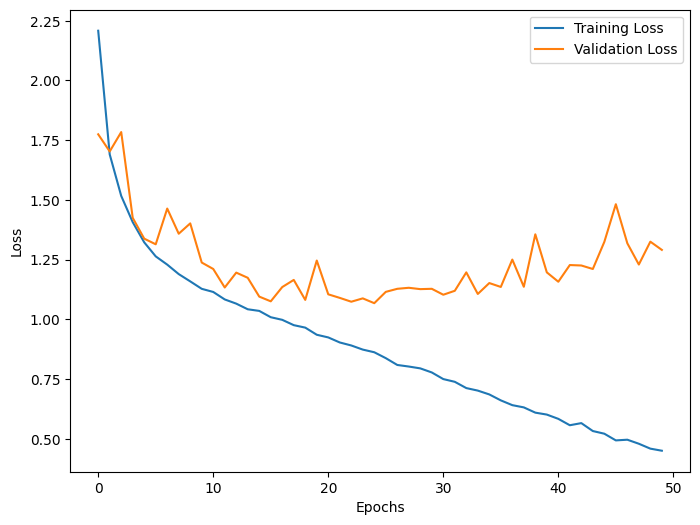

In [124]:
model = FaceExpressionNet().to(device)
summary(model, (1, 64, 64))
train(model, train_loader, valid_loader, config)

100%|██████████| 23/23 [00:03<00:00,  6.95it/s]


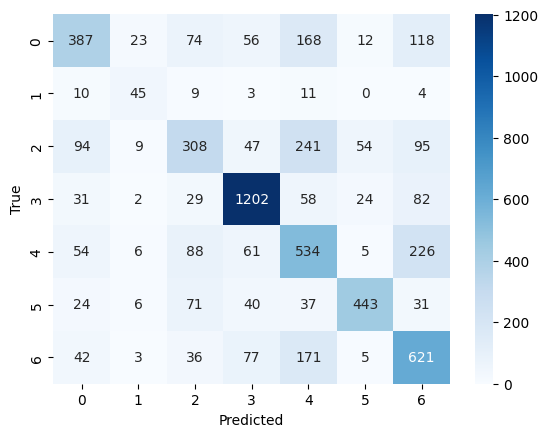

In [125]:
def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
    # TODO draw the confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

draw_confusion_matrix(model, valid_loader)


### Testing

In [126]:
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [127]:
model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)

100%|██████████| 28/28 [00:03<00:00,  8.76it/s]
